In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load in the input variables from excel sheet 'input_mode.xlsx'
# Each different input is on a different sheet in the excel file

df_capacity = pd.read_excel('input_mod.xlsx',
                            sheet_name='capacity',
                            index_col='week')
df_referrals = pd.read_excel('input_mod.xlsx',
                             sheet_name='referrals',
                             index_col='week')
df_stock = pd.read_excel('input_mod.xlsx',
                         sheet_name='stock',
                         index_col='stage')
df_TM_twoWeek = pd.read_excel('input_mod.xlsx',
                              sheet_name='TM_twoWeek',
                              index_col='idx')
df_TM_urgent = pd.read_excel('input_mod.xlsx',
                             sheet_name='TM_urgent',
                             index_col='idx')
df_TM_routine = pd.read_excel('input_mod.xlsx',
                              sheet_name='TM_routine',
                              index_col='idx')

In [ ]:
# Number of weeks to forecast
weeks = len(df_capacity)

In [3]:
def generate_waiting_list(capacity_df, referrals_df, stock_df, stage, num_weeks):
    """
    Generates the waiting list for a given stage.
    
    inputs: capacity_df: Capacity dataframe containing capacity for each stage
            referrals_df: Referrals dataframe containing the number of GP referrals for each priority
            stock_df: The stock (starting) waiting lists for each stage and each priority
            stage: The stage (location) that you want to generate the waiting list for
            num_weeks: Number of weeks you want to simulate the waiting list for
            
    outputs: df_WL: Contains the waiting list dataframe for the given stage. Also contains number
                    of patients seen for each priority and each simulated week
    """
    # initialise waiting list df
    d = {'week':list(range(0,num_weeks+1)),
         'twoWeek_WL':0,'urgent_WL':0,'routine_WL':0,
         'twoWeek_seen':0,'urgent_seen':0,'routine_seen':0}
    df_WL = pd.DataFrame(d)
    df_WL = df_WL.set_index('week')
    
    # set stock values as the waiting list value for week 0
    df_WL.loc[0,['twoWeek_WL','urgent_WL','routine_WL']] = stock_df.loc[stage].values
    
    # for each week that we want to generate the waiting list
    for i in range(1,num_weeks+1):
        # get previous week's waiting list value
        twoWeek_old_WL, urgent_old_WL, routine_old_WL = df_WL.loc[i-1,['twoWeek_WL','urgent_WL','routine_WL']].values
        # get referral values
        twoWeek_referral, urgent_referral, routine_referral = referrals_df.loc[i].values
        # get capacity values
        capacity = capacity_df.loc[i,stage]
        
        # new twoWeek WL = (old twoWeek WL) + (twoWeek referrals) - (capacity used by twoWeek patients)
        # Capacity used is going to be the smaller of the avaiable capacity and old WL + referrals
        twoWeek_capacity_used = min(twoWeek_old_WL + twoWeek_referral, capacity)
        twoWeek_new_WL = twoWeek_old_WL + twoWeek_referral - twoWeek_capacity_used
        
        # new urgent WL = (old urgent WL) + (urgent referrals) - (capacity used by urgent patients)
        # capacity avaiable to urgent patients = total capacity - capacity used by 2week patients
        # therefore, capacity used by urgent patients = capacity available
        urgent_capacity_available = capacity - twoWeek_capacity_used
        urgent_capacity_used = min(urgent_old_WL + urgent_referral, urgent_capacity_available)
        urgent_new_WL = urgent_old_WL + urgent_referral - urgent_capacity_used
        
        # Same logic for routine
        routine_capacity_available = urgent_capacity_available - urgent_capacity_used
        routine_capacity_used = min(routine_old_WL + routine_referral, routine_capacity_available)
        routine_new_WL = routine_old_WL + routine_referral - routine_capacity_used
        
        df_WL.loc[i] = [twoWeek_new_WL, urgent_new_WL, routine_new_WL,
                        twoWeek_capacity_used, urgent_capacity_used, routine_capacity_used]
          
    return df_WL

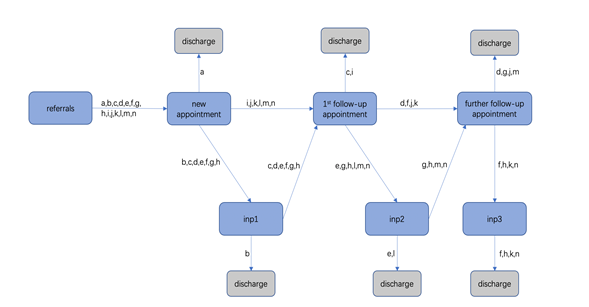

In [46]:
def inflow(from_stage, to_stage, from_df):
    """
    inflow function
    
    inputs: from_stage: The stage to calculate inflow from
            to_stage: The stage to calculate inflow to
            from_df: The waiting list dataframe generated using generate_waiting_list
                        which contains number of patients seen 
                        
    outputs: inflow_df: Dataframe with one column for each priority containing estimated inflow
    
    """
    # Get transition probabilities for each priority  
    twoWeek_probability = df_TM_twoWeek.loc[from_stage,to_stage]
    urgent_probability = df_TM_urgent.loc[from_stage,to_stage]
    routine_probability = df_TM_routine.loc[from_stage,to_stage]
    
    # Get the number of patients seen at each priority 
    twoWeek_seen = from_df.twoWeek_seen.values
    urgent_seen = from_df.urgent_seen.values
    routine_seen = from_df.routine_seen.values
    
    # Estimate inflow
    inflow = {'twoWeek_inflow':from_df.twoWeek_seen.values*twoWeek_probability,
              'urgent_inflow':from_df.urgent_seen.values*urgent_probability,
              'routine_inflow':from_df.routine_seen.values*routine_probability}
    
    inflow_df = pd.DataFrame(inflow).loc[1:]
    
    return inflow_df

In [47]:
# Generate waiting list for 'new appointment' stage, with inflow being GP referrals

df_WL_new = generate_waiting_list(df_capacity, df_referrals, df_stock, 'new', weeks)

In [48]:
### inp1 stage: 
# Inflow: 'new'
# Outflow: '1FU'

inflow_new_inp1 = inflow('new','inp1', df_WL_new)
df_WL_inp1 = generate_waiting_list(df_capacity, inflow_new_inp1, df_stock, 'inp1', weeks)

In [49]:
### 1FU stage:
# Inflow: 'new', 'inp1'
# Outflow: 'inp2', 'FU'

inflow_new_1FU = inflow('new', '1FU', df_WL_new)
inflow_inp1_1FU = inflow('inp1', '1FU', df_WL_inp1)

df_WL_1FU = generate_waiting_list(df_capacity,
                                  inflow_new_1FU + inflow_inp1_1FU, df_stock,
                                  stage='1FU', 
                                  num_weeks=weeks)

In [50]:
### inp2 stage:
# Inflow: '1FU'
# Outflow: 'FU'

inflow_1FU_inp2 = inflow('1FU', 'inp2', df_WL_1FU)

df_WL_inp2 = generate_waiting_list(df_capacity, inflow_1FU_inp2, df_stock, stage='inp2', num_weeks=weeks)

In [51]:
### FU stage:
# Inflow: '1FU', 'imp2'
# Outflow: 'imp3'

inflow_1FU_FU = inflow('1FU', 'FU', df_WL_1FU)
inflow_inp2_FU = inflow('inp2', 'FU', df_WL_inp2)

df_WL_FU = generate_waiting_list(df_capacity,
                                 inflow_1FU_FU + inflow_inp2_FU,
                                 df_stock,
                                 stage='FU',
                                 num_weeks=weeks)

In [52]:
### inp3 stage:
# Inflow: 'FU'
# Outflow:

inflow_FU_inp3 = inflow('FU', 'inp3', df_WL_FU)

df_WL_inp3 = generate_waiting_list(df_capacity,inflow_FU_inp3,df_stock,stage='inp3',num_weeks=weeks)

In [53]:
def calculate_waiting_times(df_WL):
    """
    calculate_waiting_times
    
    input: df_WL: The waiting list dataframe for a stage, generated from generate_waiting_list function
    output: WL_df: The waiting time dataframe generated for this stage
    
    """
    
    # initialise waiting time dataframe with one column for each priority and one for 
    WT_df = pd.DataFrame({'twoWeek_WT':0, 'urgent_WT':0, 'routine_WT':0}, index=[i for i in range(1,1+weeks)])
    # Store the waiting list for each priority in WT_new
    WT_new = df_WT[['twoWeek_WL','urgent_WL','routine_WL']]
    # Rename columns
    WT_new = WT_new.rename(columns={'twoWeek_WL':'twoWeek','urgent_WL':'urgent','routine_WL':'routine'})

    # For each simulated week (not including base stock week 0)
    for week in range(1,weeks+1):
        # Get the cumulative number of patients seen from this week onwards for this site, for all priorities
        cumulative_seen = df_WT.loc[week:,['twoWeek_seen', 'urgent_seen','routine_seen']].cumsum()
        # Need to rename the columns because Python only lets column-wise comparision happen
        # when the columns in each of the dataframes are named the same
        cumulative_seen = cumulative_seen.rename(columns={
        'twoWeek_seen': 'twoWeek',
        'urgent_seen': 'urgent',
        'routine_seen': 'routine'
        })
    
        # Find what week that the number of patients waiting will be seen
        bool_df = cumulative_seen.where(cumulative_seen >= WT_new.loc[week])
        first_valid_loc = bool_df.apply(lambda col: col.first_valid_index())-week
        WT_df.loc[week] = first_valid_loc.values
        
    return WL_df